# Data wrangling part 2: scaling and resampling

### Action Plan
- Scale "amount" and "time" features to match remaining
- Check "describe" on features to confirm scale
- Will need to subsample and/or oversample to balance classes
- Do comparative heatmaps, boxplots, histplots (see if I can save images from EDA)
- Retry easy/difficult visualization on sampled data
- Do the sampling BEFORE train/test splitting (! no, other way around? https://imbalanced-learn.org/stable/common_pitfalls.html)
- Remember outlier corrections
- Try both subsampling and oversampling to see if either produces "better" results
- Extra credit: repeat from the sampling step as a kind of cross-validation of the sampling tactic

### Notes:
- You may need to install imblearn (imbalanced-learn)
- You may need to download data yourself (too big to upload with my current GitHub file size limit)
    -  https://www.kaggle.com/mlg-ulb/creditcardfraud
- Credit to https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
- and to https://www.kaggle.com/hazratnit/credit-fraud-detection
- easy/difficult visualization from https://www.researchgate.net/publication/283349138_Calibrating_Probability_with_Undersampling_for_Unbalanced_Classification (Section III-D)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Other Libraries
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_csv('data\creditcard.csv')

In [2]:
# Check "describe" on features to confirm scale
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Hmpf. My scale goes from negative single-digits to positive tens with the occasional hundred-ish, and not on a super logical scale. Let's see what the scaler produces.

In [3]:
# Scale "amount" and "time" features to match remaining
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['std_scaled_amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['std_scaled_time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df['rob_scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['rob_scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df[['std_scaled_amount', 'std_scaled_time', 'rob_scaled_amount', 'rob_scaled_time']].describe()


,std_scaled_amount,std_scaled_time,rob_scaled_amount,rob_scaled_time
count,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,3.202236e-16,-1.050379e-14,0.927124,0.118914
std,1.000002e+00,1.000002e+00,3.495006,0.557903
min,-3.532294e-01,-1.996583e+00,-0.307413,-0.994983
25%,-3.308401e-01,-8.552120e-01,-0.229162,-0.358210
50%,-2.652715e-01,-2.131453e-01,0.000000,0.000000
75%,-4.471707e-02,9.372174e-01,0.770838,0.641790
max,1.023622e+02,1.642058e+00,358.683155,1.035022


I think I will use standard scaler because it seems more like the PCA-transformed data.

In [4]:
df.drop(['Time','Amount', 'rob_scaled_amount', 'rob_scaled_time'], axis=1, inplace=True)

In [5]:
# train/test split BEFORE under or over sampling
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# split Class balance evaluation
classcount = y_train.value_counts()
perc_pos = (classcount[1]/(classcount[0]+classcount[1]))*100
print("Training Data contains {} fraudulent transactions which are {:.3f}% of all transactions".format(classcount[1], perc_pos))
classcount = y_test.value_counts()
perc_pos = (classcount[1]/(classcount[0]+classcount[1]))*100
print("Test Data contains {} fraudulent transactions which are {:.3f}% of all transactions".format(classcount[1], perc_pos))
print("Original Data contains 492 fraudulent transactions which are 0.173% of all transactions") # calculated in data wrangling

Training Data contains 344 fraudulent transactions which are 0.173% of all transactions
Test Data contains 148 fraudulent transactions which are 0.173% of all transactions
Original Data contains 492 fraudulent transactions which are 0.173% of all transactions


In [6]:
# do one subsample and one oversample before creating pipelines, to see if EDA reveals any other features to watch
subsample = RandomUnderSampler(random_state=42)
oversample = SMOTE(random_state=42)

X_sub, y_sub = subsample.fit_resample(X_train, y_train)
X_over, y_over = oversample.fit_resample(X_train, y_train)

# Recombine resampled data for EDA
dfsub = pd.concat([X_sub, y_sub], axis=1)
dfover = pd.concat([X_over, y_over], axis=1)

# subsampled Class balance evaluation
classcount = dfsub.Class.value_counts()
perc_pos = (classcount[1]/(classcount[0]+classcount[1]))*100
print("Subsampled Data contains {} fraudulent transactions which are {:.3f}% of all transactions".format(classcount[1], perc_pos))
# oversampled Class balance evaluation
classcount = dfover.Class.value_counts()
perc_pos = (classcount[1]/(classcount[0]+classcount[1]))*100
print("Oversampled Data contains {} fraudulent transactions which are {:.3f}% of all transactions".format(classcount[1], perc_pos))

Subsampled Data contains 344 fraudulent transactions which are 50.000% of all transactions
Oversampled Data contains 199020 fraudulent transactions which are 50.000% of all transactions


<AxesSubplot:>

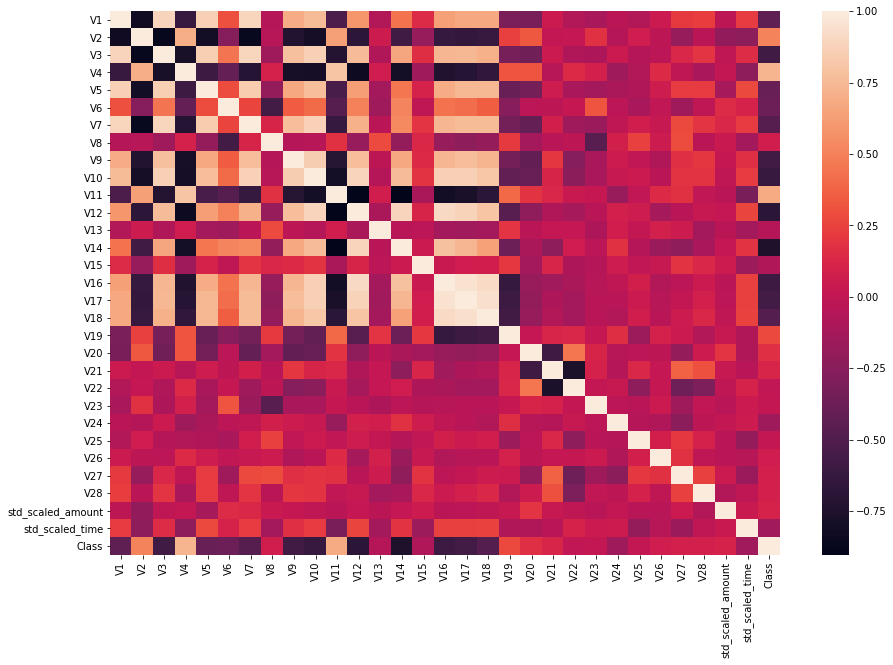

In [7]:
# subsampled correlation
corrsub = dfsub.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrsub)

In [8]:
# checking for strong negative correlations
corrsub[corrsub.Class < -0.5]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,std_scaled_amount,std_scaled_time,Class
V3,0.882218,-0.871463,1.000000,-0.778099,0.852701,0.448997,0.889184,-0.156254,0.778261,0.866254,...,-0.081418,-0.091542,0.044130,-0.058117,-0.020846,0.129924,0.192955,-0.003973,0.156854,-0.577853
V9,0.688364,-0.726640,0.778261,-0.788266,0.674809,0.348735,0.773617,-0.055602,1.000000,0.850148,...,-0.262202,-0.114075,0.053674,-0.001158,-0.084670,0.172076,0.200017,0.022435,0.173707,-0.571542
V10,0.755105,-0.791156,0.866254,-0.794029,0.773498,0.412483,0.867756,-0.042143,0.850148,1.000000,...,-0.235921,-0.110290,0.027420,0.041740,-0.027061,0.189453,0.185015,-0.005725,0.221694,-0.626994
V12,0.588486,-0.673483,0.768379,-0.837752,0.625136,0.501119,0.711996,-0.183167,0.772757,0.886353,...,-0.114975,-0.038240,0.091778,0.060329,-0.120812,-0.033439,0.029881,0.019011,0.257306,-0.683614
V14,0.440616,-0.575656,0.665412,-0.802244,0.450294,0.516489,0.538840,-0.201690,0.680382,0.764992,...,0.066201,-0.023999,0.182029,-0.048102,-0.168760,-0.213094,-0.107370,0.019084,0.185632,-0.754362
V16,0.630596,-0.629810,0.733187,-0.733423,0.691626,0.436714,0.735565,-0.185522,0.735646,0.862032,...,-0.103744,-0.041886,-0.007695,0.080642,-0.067964,-0.021462,0.048059,-0.031679,0.241385,-0.600367
V17,0.670065,-0.644553,0.740900,-0.715554,0.745977,0.419773,0.760911,-0.225338,0.769726,0.861219,...,-0.130192,-0.037737,-0.037302,0.043643,-0.044882,0.010840,0.087498,-0.019867,0.238062,-0.567619


In [9]:
# checking for strong positive correlations
corrsub[corrsub.Class > 0.5]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,std_scaled_amount,std_scaled_time,Class
V2,-0.827537,1.000000,-0.871463,0.695956,-0.805887,-0.255696,-0.862396,-0.043119,-0.726640,-0.791156,...,0.018088,0.182033,-0.052651,0.070044,-0.016807,-0.184214,-0.029067,-0.208622,-0.225788,0.503324
V4,-0.625055,0.695956,-0.778099,1.000000,-0.591403,-0.406684,-0.714344,0.098066,-0.788266,-0.794029,...,0.141172,0.086937,-0.152861,-0.068124,0.144262,-0.007048,-0.108041,0.005365,-0.221826,0.728448
V11,-0.519599,0.631223,-0.722996,0.805095,-0.533653,-0.478376,-0.630297,0.181750,-0.704792,-0.803640,...,0.034770,0.020893,-0.178678,0.002210,0.140746,0.177578,0.000185,-0.029692,-0.320671,0.686032
Class,-0.432616,0.503324,-0.577853,0.728448,-0.391622,-0.375116,-0.477181,0.071381,-0.571542,-0.626994,...,0.001953,0.008764,-0.151197,0.007604,0.067634,0.089183,0.092715,0.101960,-0.137882,1.000000


<AxesSubplot:>

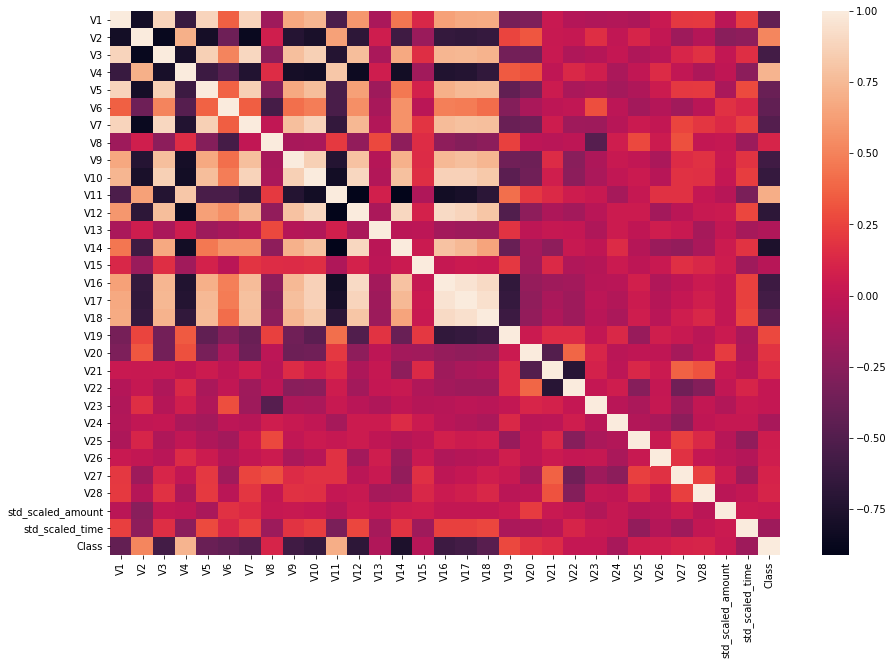

In [10]:
# oversampled correlation
corrover = dfover.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrover)

In [11]:
# checking for strong negative correlations
corrover[corrover.Class < -0.5]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,std_scaled_amount,std_scaled_time,Class
V3,0.884007,-0.871088,1.000000,-0.789193,0.865045,0.508866,0.901174,-0.233891,0.777119,0.860791,...,-0.086820,-0.059271,0.013723,-0.088329,-0.037900,0.116611,0.172673,0.000106,0.158763,-0.568191
V9,0.667225,-0.718522,0.777119,-0.805945,0.677882,0.422411,0.782643,-0.117579,1.000000,0.861690,...,-0.250881,-0.091670,0.024885,-0.000607,-0.103858,0.142679,0.172077,0.027263,0.184338,-0.589987
V10,0.737498,-0.779860,0.860791,-0.820612,0.769127,0.481942,0.874131,-0.111511,0.861690,1.000000,...,-0.237703,-0.098235,-0.003046,0.042778,-0.049855,0.171996,0.167011,0.010233,0.224514,-0.642054
V12,0.594262,-0.685757,0.774468,-0.847510,0.633962,0.555340,0.742224,-0.215959,0.791707,0.902070,...,-0.140597,-0.041308,0.050251,0.050663,-0.140950,-0.032263,0.026507,0.041503,0.262592,-0.682534
V14,0.450066,-0.594147,0.674116,-0.820047,0.460469,0.569930,0.573792,-0.228392,0.709872,0.786280,...,0.022662,-0.009457,0.142617,-0.059155,-0.177905,-0.208561,-0.108210,0.044621,0.185159,-0.763328
V16,0.635279,-0.646170,0.737006,-0.742476,0.701843,0.489893,0.762503,-0.231557,0.752813,0.872533,...,-0.140221,-0.045294,-0.042834,0.076168,-0.080679,-0.016030,0.042012,0.000670,0.244269,-0.597584
V17,0.674325,-0.659015,0.745600,-0.728717,0.752969,0.477391,0.786629,-0.271332,0.780671,0.871088,...,-0.157172,-0.029285,-0.071204,0.044765,-0.059950,0.009784,0.070693,0.001580,0.245526,-0.568614


In [12]:
# checking for strong positive correlations
corrover[corrover.Class > 0.5]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,std_scaled_amount,std_scaled_time,Class
V2,-0.810700,1.000000,-0.871088,0.704620,-0.802733,-0.370884,-0.859516,0.074178,-0.718522,-0.779860,...,0.017570,0.157194,-0.005199,0.108019,0.007156,-0.157833,-0.057112,-0.250411,-0.228465,0.521618
V4,-0.624295,0.704620,-0.789193,1.000000,-0.606777,-0.482217,-0.734207,0.149903,-0.805945,-0.820612,...,0.128749,0.068007,-0.102806,-0.007471,0.143896,-0.003335,-0.092325,-0.013239,-0.236916,0.727186
V11,-0.525660,0.638091,-0.727688,0.820435,-0.542573,-0.541515,-0.657085,0.215358,-0.726067,-0.819616,...,0.057461,0.028757,-0.125762,0.018299,0.173785,0.172727,0.014548,-0.047941,-0.316848,0.694905
Class,-0.418383,0.521618,-0.568191,0.727186,-0.390469,-0.429319,-0.489499,0.104289,-0.589987,-0.642054,...,0.013279,0.008680,-0.114044,0.058717,0.065457,0.100371,0.110245,0.030870,-0.163264,1.000000


So, it looks like subsampling and oversampling produce similar correlation patterns in the results. Let's try the boxplots and the easy/difficult histogram again!

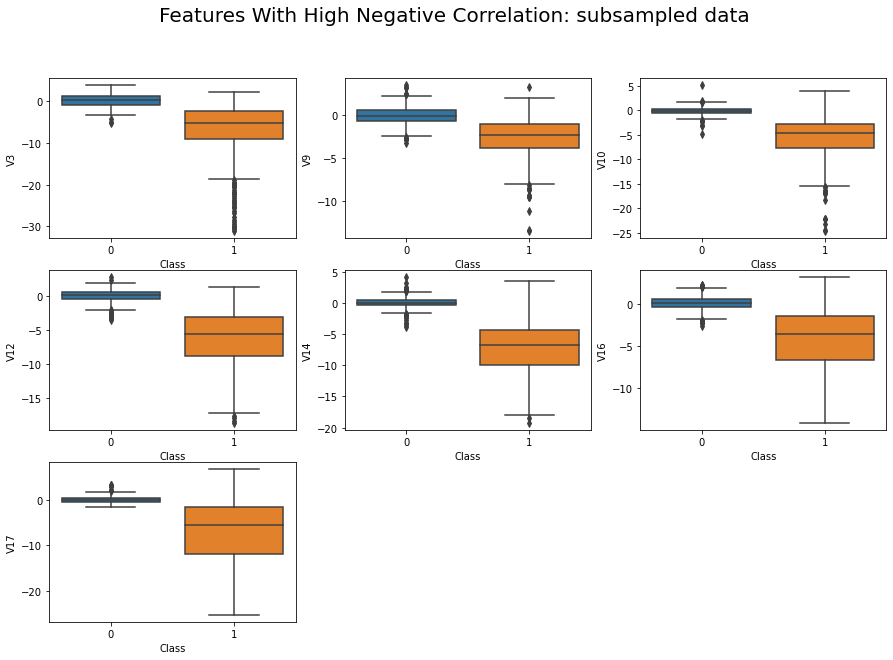

In [13]:
# Do boxplots of highly positive/negative correlations
f, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

f.suptitle('Features With High Negative Correlation: subsampled data', size=20)
sns.boxplot(x="Class", y="V3", data=dfsub, ax=axes[0,0])
sns.boxplot(x="Class", y="V9", data=dfsub, ax=axes[0,1])
sns.boxplot(x="Class", y="V10", data=dfsub, ax=axes[0,2])
sns.boxplot(x="Class", y="V12", data=dfsub, ax=axes[1,0])
sns.boxplot(x="Class", y="V14", data=dfsub, ax=axes[1,1])
sns.boxplot(x="Class", y="V16", data=dfsub, ax=axes[1,2])
sns.boxplot(x="Class", y="V17", data=dfsub, ax=axes[2,0])
f.delaxes(axes[2,1])
f.delaxes(axes[2,2])

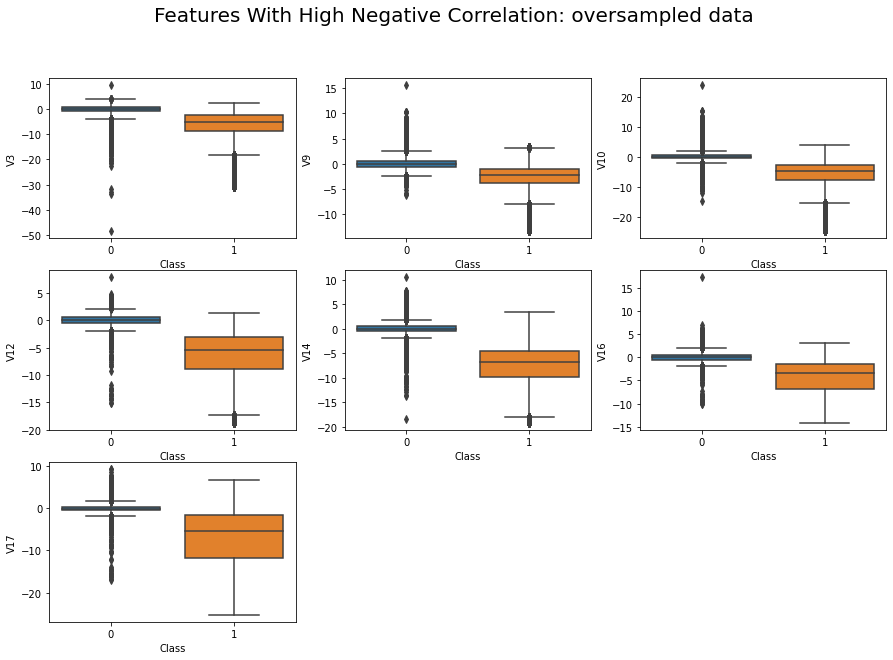

In [14]:
f, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

f.suptitle('Features With High Negative Correlation: oversampled data', size=20)
sns.boxplot(x="Class", y="V3", data=dfover, ax=axes[0,0])
sns.boxplot(x="Class", y="V9", data=dfover, ax=axes[0,1])
sns.boxplot(x="Class", y="V10", data=dfover, ax=axes[0,2])
sns.boxplot(x="Class", y="V12", data=dfover, ax=axes[1,0])
sns.boxplot(x="Class", y="V14", data=dfover, ax=axes[1,1])
sns.boxplot(x="Class", y="V16", data=dfover, ax=axes[1,2])
sns.boxplot(x="Class", y="V17", data=dfover, ax=axes[2,0])
f.delaxes(axes[2,1])
f.delaxes(axes[2,2])

Interesting. There appear to be more outliers, especially in the non-fraud class, when using oversampled data.

<AxesSubplot:xlabel='Class', ylabel='V11'>

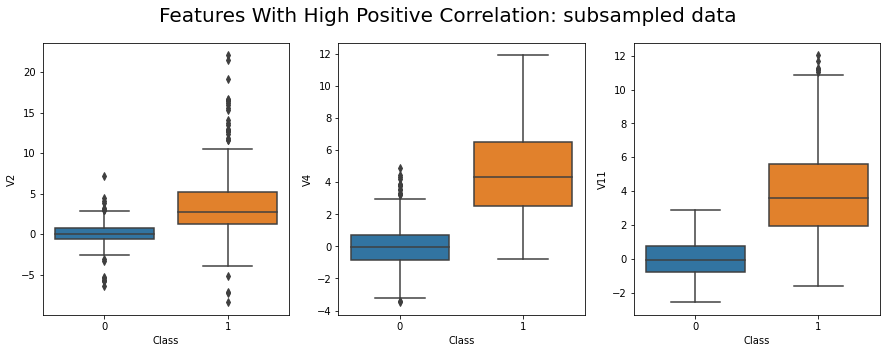

In [15]:
# check high positive correlations
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

f.suptitle('Features With High Positive Correlation: subsampled data', size=20)
sns.boxplot(x="Class", y="V2", data=dfsub, ax=axes[0])
sns.boxplot(x="Class", y="V4", data=dfsub, ax=axes[1])
sns.boxplot(x="Class", y="V11", data=dfsub, ax=axes[2])


<AxesSubplot:xlabel='Class', ylabel='V11'>

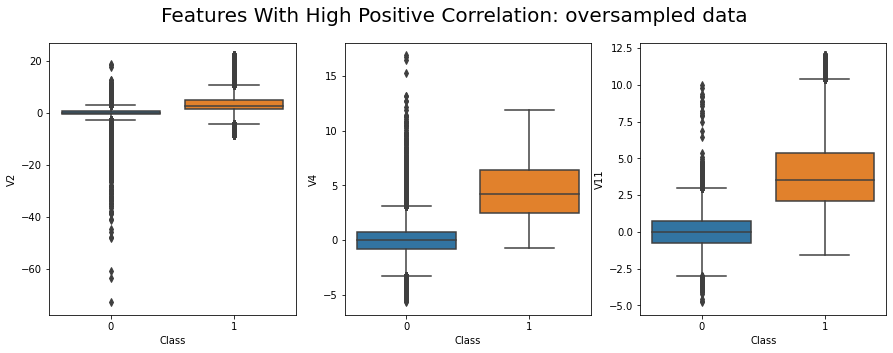

In [16]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

f.suptitle('Features With High Positive Correlation: oversampled data', size=20)
sns.boxplot(x="Class", y="V2", data=dfover, ax=axes[0])
sns.boxplot(x="Class", y="V4", data=dfover, ax=axes[1])
sns.boxplot(x="Class", y="V11", data=dfover, ax=axes[2])

This is interesting both in the reversion of the pattern I originally noticed, where the negatively-correlated features all have a lower distribution in the fraud class than the non-fraud class. (Is this basically the definition of correlation?) Also, the trend of oversampling to produce a lot more outliers in the non-fraud class appears to continue here.

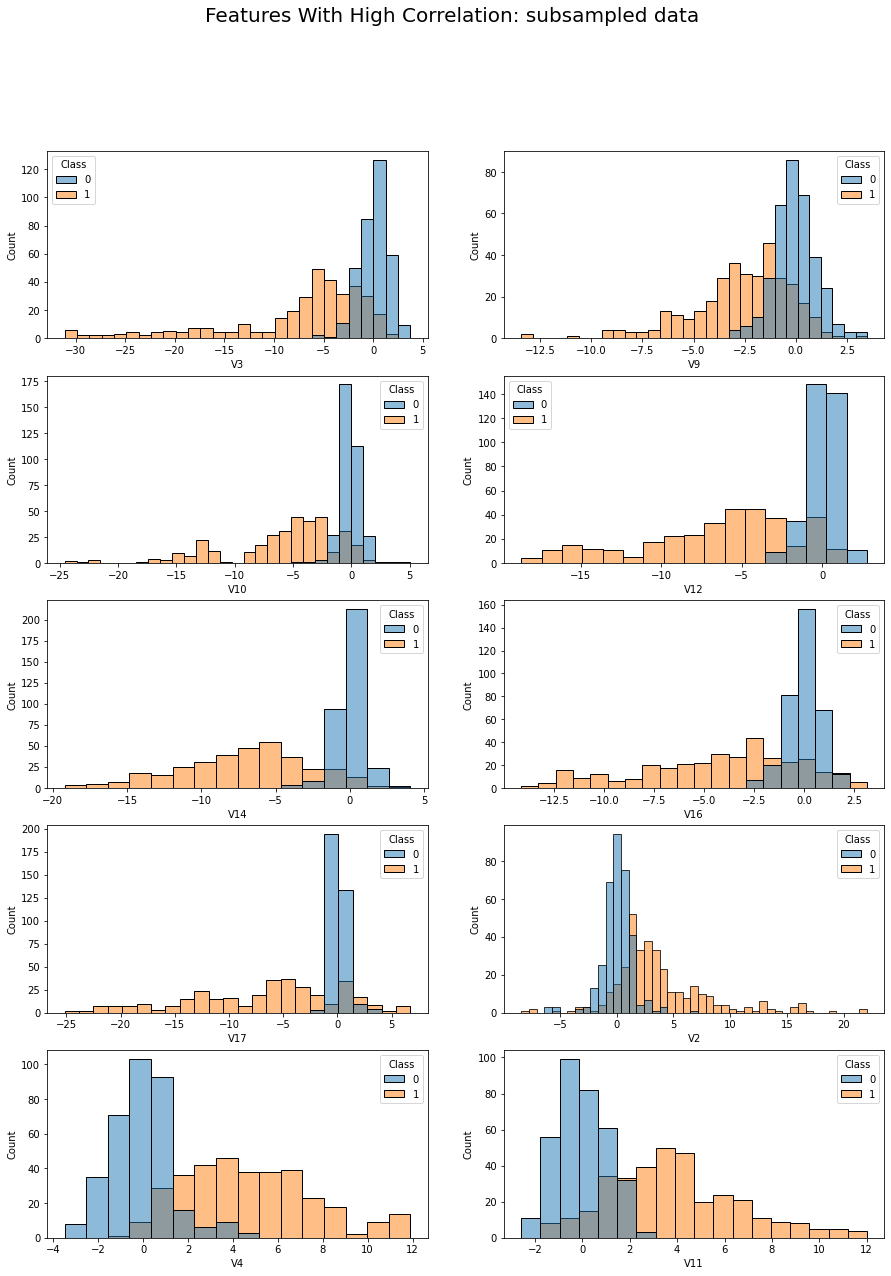

In [17]:
# A crack at "easy/difficult" detection of feature separation by class.
mostcorr = ['V3','V9','V10','V12','V14','V16','V17','V2', 'V4', 'V11']

f, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,20))
f.suptitle('Features With High Correlation: subsampled data', size=20)
row = 0
col = 0
for feature in mostcorr:
    sns.histplot(data=dfsub, x=feature, hue='Class', ax=axes[row,col])
    col += 1
    if col > 1:
        col = 0
        row += 1

Aha! This is what I couldn't see in the original data, because the fraud class was so small. These will mostly be considered "difficult" classification problems, because the classes overlap in most cases. Still, I can see in these more strongly correlated features that the fraud class usually has a much flatter distribution.

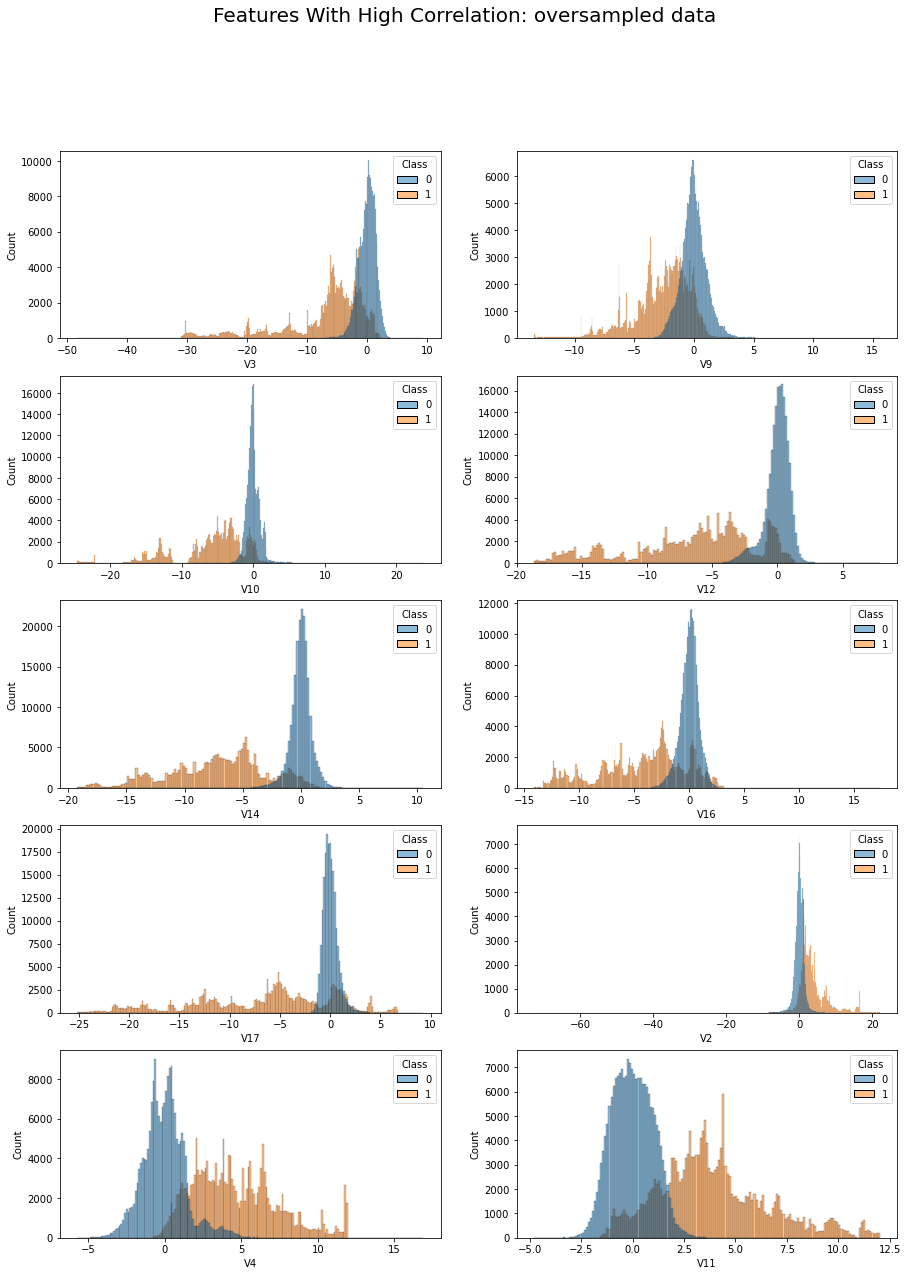

In [18]:
mostcorr = ['V3','V9','V10','V12','V14','V16','V17','V2', 'V4', 'V11']

f, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,20))
f.suptitle('Features With High Correlation: oversampled data', size=20)
row = 0
col = 0
for feature in mostcorr:
    sns.histplot(data=dfover, x=feature, hue='Class', ax=axes[row,col])
    col += 1
    if col > 1:
        col = 0
        row += 1

Here's a guess: my current bet is that oversampling will work better for learning because it produces many more data points. Let's find out!

In [19]:
# Do I need to correct for outliers?
Q1 = dfsub.quantile(0.25)
Q3 = dfsub.quantile(0.75)
IQR = Q3 - Q1

IQR.head()

V1    3.755701
V2    2.990036
V3    5.605562
V4    4.456119
V5    2.415055
dtype: float64

In [20]:
outliers = dfsub[((dfsub < (Q1 - 2.5 * IQR)) |(dfsub > (Q3 + 2.5 * IQR))).any(axis=1)]
outliers.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,std_scaled_amount,std_scaled_time,Class
3,-1.177645,1.391676,1.757402,0.106519,1.034517,1.245790,0.844486,-0.376810,-0.174472,0.951936,...,-0.252530,-0.395049,-1.357082,0.092931,-0.586498,-1.493762,-0.888026,-0.333239,-0.315171,0
28,-7.612598,7.159339,-5.072827,1.199474,-3.108766,2.908822,-10.578084,-14.649024,-3.216418,-4.782846,...,3.006540,1.694142,-0.620285,-0.677250,-0.465063,-1.539579,0.072401,-0.349231,-0.347832,0
34,-2.061106,2.199726,-0.911984,1.102492,-2.932179,2.028322,0.968097,-2.948850,1.599916,-1.085649,...,-2.020613,0.528408,-0.181949,-0.883351,-1.181276,0.152724,-0.229197,1.604873,0.311997,0
35,-1.574913,0.051224,-0.600985,-0.463122,-5.467420,2.338382,6.104438,-1.343913,-0.453083,-1.147250,...,0.450074,0.047702,0.585418,-0.050075,1.086967,0.619743,-0.402418,4.440476,-0.717504,0
36,-3.309530,-3.030357,-0.403419,-1.767371,-3.988848,1.831865,4.502206,0.238375,0.310114,-3.146708,...,0.213320,2.655916,0.472023,1.185621,0.621137,-0.631388,0.071162,4.890101,0.899850,0


In [21]:
print("Outlier rows: ", len(outliers))

Outlier rows:  194


In [22]:
print("Subsample rows: ", len(dfsub))

Subsample rows:  688


Hmm. Removing rows with "any" outliers would take out 28% of my subsampled dataset. Probably would want to go up to 3x IQR. Let's see what it's like with the oversampled dataset.

In [23]:
Q1 = dfover.quantile(0.25)
Q3 = dfover.quantile(0.75)
IQR = Q3 - Q1

IQR.head()

V1    3.676195
V2    2.944856
V3    5.628196
V4    4.317081
V5    2.282573
dtype: float64

In [24]:
outliers = dfover[((dfover < (Q1 - 2.5 * IQR)) |(dfover > (Q3 + 2.5 * IQR))).any(axis=1)]
outliers.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,std_scaled_amount,std_scaled_time,Class
2,-1.083391,-4.440527,-1.399530,0.469764,-2.076458,-0.766137,1.601441,-0.709176,-1.288745,0.086419,...,-1.432833,-1.097063,0.505926,-0.140185,0.870190,-0.316982,0.227833,4.854238,-0.527203,0
4,-0.640421,0.212171,0.283341,-1.786916,2.616127,4.024863,-0.198897,0.937087,0.474428,-0.283699,...,0.759218,-0.321412,0.767971,-0.084221,0.612936,0.074029,-0.033344,-0.335278,0.727259,0
17,-0.517706,0.501920,0.914578,-1.250159,2.631545,4.191335,-0.091213,0.841754,1.358565,-1.127721,...,-0.562641,-0.244051,0.596494,0.305084,-0.707293,-0.063768,-0.151720,-0.308171,0.280031,0
18,-0.509292,1.871228,0.789716,0.677913,2.435246,-1.252302,3.005140,-2.272412,0.395945,0.389462,...,0.263718,-0.558013,0.301979,-0.224335,-0.692899,-2.095776,-1.569406,-0.349231,-1.389420,0
20,0.450187,-2.849845,-0.315506,-0.946477,-1.946496,-0.231622,-0.352677,-0.135816,-1.798527,1.307254,...,-0.846770,-0.463009,-0.028848,0.205774,-0.302378,-0.081646,0.096035,1.852755,-1.045333,0


In [25]:
print("Outlier rows: ", len(outliers))

Outlier rows:  104885


In [26]:
print("Oversample rows: ", len(dfover))

Oversample rows:  398040


Similar, outliers at 2.5x IQR are 26% of the dataset.

In [27]:
outliers = dfover[((dfover < (Q1 - 3 * IQR)) |(dfover > (Q3 + 3 * IQR))).any(axis=1)]
print("Outlier rows at 3x IQR: ", len(outliers))

Outlier rows at 3x IQR:  88660


That's still 22%! 

I'm noticing that one of my inspiration notebooks only looked at outliers on a few of the highly correlated features. (https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets) And, as I look closer, only the outliers of the fraud class. So they took out very few instances, maybe 0.5% -- but all fraud instances, which are the limited ones.

The other inspiration notebook just went straight for the "drop any outlier rows" tactic I've been looking at, and indeed they came up with about a 30% reduction in their undersampled dataset.

I think I do not want to drop outliers right now. I might come back to it as a "does my favorite model work better if I drop outliers" option toward the end. Scope creep, watch out! 